# Variational Auto-encoder

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data 
from collections import defaultdict
from tqdm import tqdm
import sys
sys.path.append('../python/')
%load_ext autoreload

tf.logging.set_verbosity(tf.logging.ERROR)
tf.logging.set_verbosity(tf.logging.WARN)
tf.logging.set_verbosity(tf.logging.DEBUG)
tf.logging.set_verbosity(tf.logging.FATAL)
import warnings
warnings.filterwarnings("ignore", module="matplotlib")

np.random.seed(1234)
tf.set_random_seed(1234)

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
X_train, X_test = mnist.train, mnist.test

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
%autoreload
from vae import VAE, LogDerTrickVAE, MonteKarloVAE, NVILVAE, MuPropVAE
from utils import train, get_gradient_mean_and_std

In [4]:
n_samples = mnist.train.num_examples
n_input = 784
n_z = 20
batch_size = 128
weights_save_step = 50
save_path = 'saved_weights/'

network_architecture = {
    'n_hidden_encoder_1': 80,
    'n_hidden_encoder_2': 80,
    'n_hidden_decoder_1': 80,
    'n_hidden_decoder_2': 80
}

### The comparison of the MonteKarlo and NVIL methods with various parameters

In [5]:
training_epochs = 100
display_step = 1
save_weights = False

In [6]:
learning_rate = 1e-4
n_monte_karlo_samples = [1, 2, 5, 10]
baseline_learning_rates = [0.1, 0.01]
vaes = [MonteKarloVAE(n_input, n_z, network_architecture, 'bernoulli', 
                      learning_rate, n_monte_karlo_samples=n_samples) 
        for n_samples in n_monte_karlo_samples]
vaes.extend([NVILVAE(n_input, n_z, network_architecture, 'bernoulli', 
                     learning_rate, baseline_learning_rate=baseline_learning_rate) 
             for baseline_learning_rate in baseline_learning_rates])
names = [str(vaes[0]) + '{}'.format(n_samples) for n_samples in n_monte_karlo_samples]
names.extend([str(vaes[4]) + '{}'.format(learning_rate) for learning_rate in baseline_learning_rates])

MonterKarloVAE1: train cost = 119.951866150, test cost = 118.937423706
MonterKarloVAE2: train cost = 119.913024902, test cost = 118.777221680
MonterKarloVAE5: train cost = 119.206176758, test cost = 118.168266296
MonterKarloVAE10: train cost = 119.714263916, test cost = 118.556549072
NVILVAE0.1: train cost = 132.605834961, test cost = 132.512802124
NVILVAE0.01: train cost = 131.609970093, test cost = 130.452270508


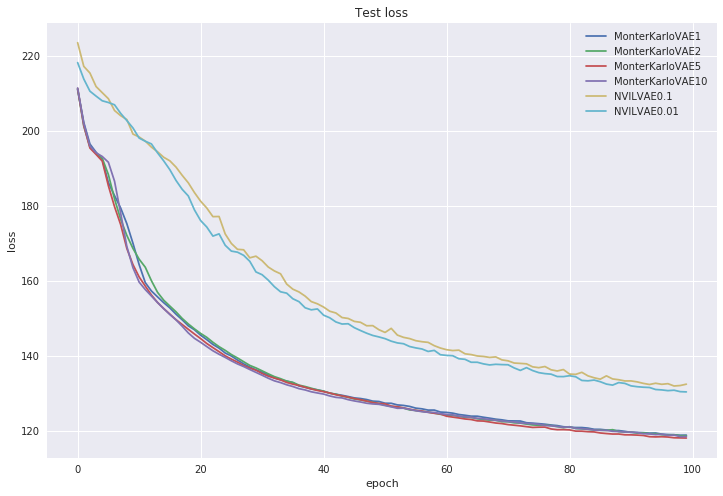

100%|██████████| 100/100 [1:53:02<00:00, 76.62s/it]


In [7]:
train(vaes, names, X_train, X_test, n_samples, batch_size, training_epochs, 
      display_step, weights_save_step, save_weights, save_path)

### The comparison of all methods

In [5]:
training_epochs = 501
display_step = 25
save_weights = True

In [6]:
vaes = [VAE, LogDerTrickVAE, MonteKarloVAE, NVILVAE, MuPropVAE]
learning_rates = [1e-3, 1e-4, 1e-4, 1e-4, 1e-4]
vaes = [vae(n_input, n_z, network_architecture, 'bernoulli', learning_rate) 
        for vae, learning_rate in zip(vaes, learning_rates)]
names = [str(vae) for vae in vaes]

ReparamTrickVAE: train cost = 103.446823120, test cost = 103.579917908
LogDerTrickVAE: train cost = 123.470024109, test cost = 122.796714783
MonterKarloVAE: train cost = 109.980346680, test cost = 109.519897461
NVILVAE: train cost = 116.847946167, test cost = 115.844001770
MuPropVAE: train cost = 109.665840149, test cost = 109.248001099


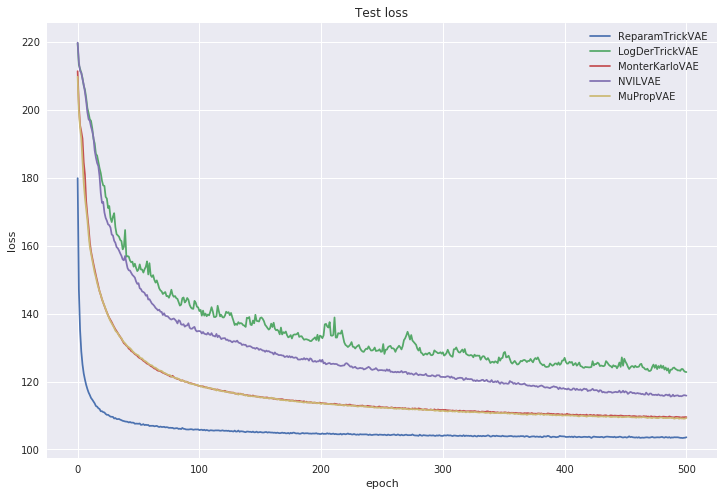

100%|██████████| 501/501 [6:36:13<00:00, 47.02s/it]


In [7]:
train(vaes, names, X_train, X_test, n_samples, batch_size, training_epochs, 
      display_step, weights_save_step, save_weights, save_path)

### The comparison of the gradient estimator variance of each method

In [6]:
vaes = [VAE, LogDerTrickVAE, NVILVAE, MonteKarloVAE, MuPropVAE]
learning_rates = [1e-3, 1e-4, 1e-4, 1e-4, 1e-4]
vaes = [vae(n_input, n_z, network_architecture, 'bernoulli', learning_rate) 
        for vae, learning_rate in zip(vaes, learning_rates)]
names = [str(vae) for vae in vaes]

In [7]:
batch_xs, _ = X_train.next_batch(batch_size)
n_iterations = 100

In [8]:
encoder_stds = defaultdict(lambda: defaultdict(list))
decoder_stds = defaultdict(lambda: defaultdict(list))

for weights_name in tqdm(names):
    for name, vae in zip(names, vaes):
        if name == 'NVILVAE' and weights_name != 'NVILVAE':
            continue
        for saved_index in range(1, training_epochs+1, weights_save_step):
            vae.restore_weights(save_path + weights_name + '_{}'.format(saved_index))
            _, encoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'encoder')
            _, decoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'decoder')
            encoder_stds[weights_name][name].append(encoder_std)
            decoder_stds[weights_name][name].append(decoder_std)

100%|██████████| 5/5 [07:56<00:00, 94.28s/it]


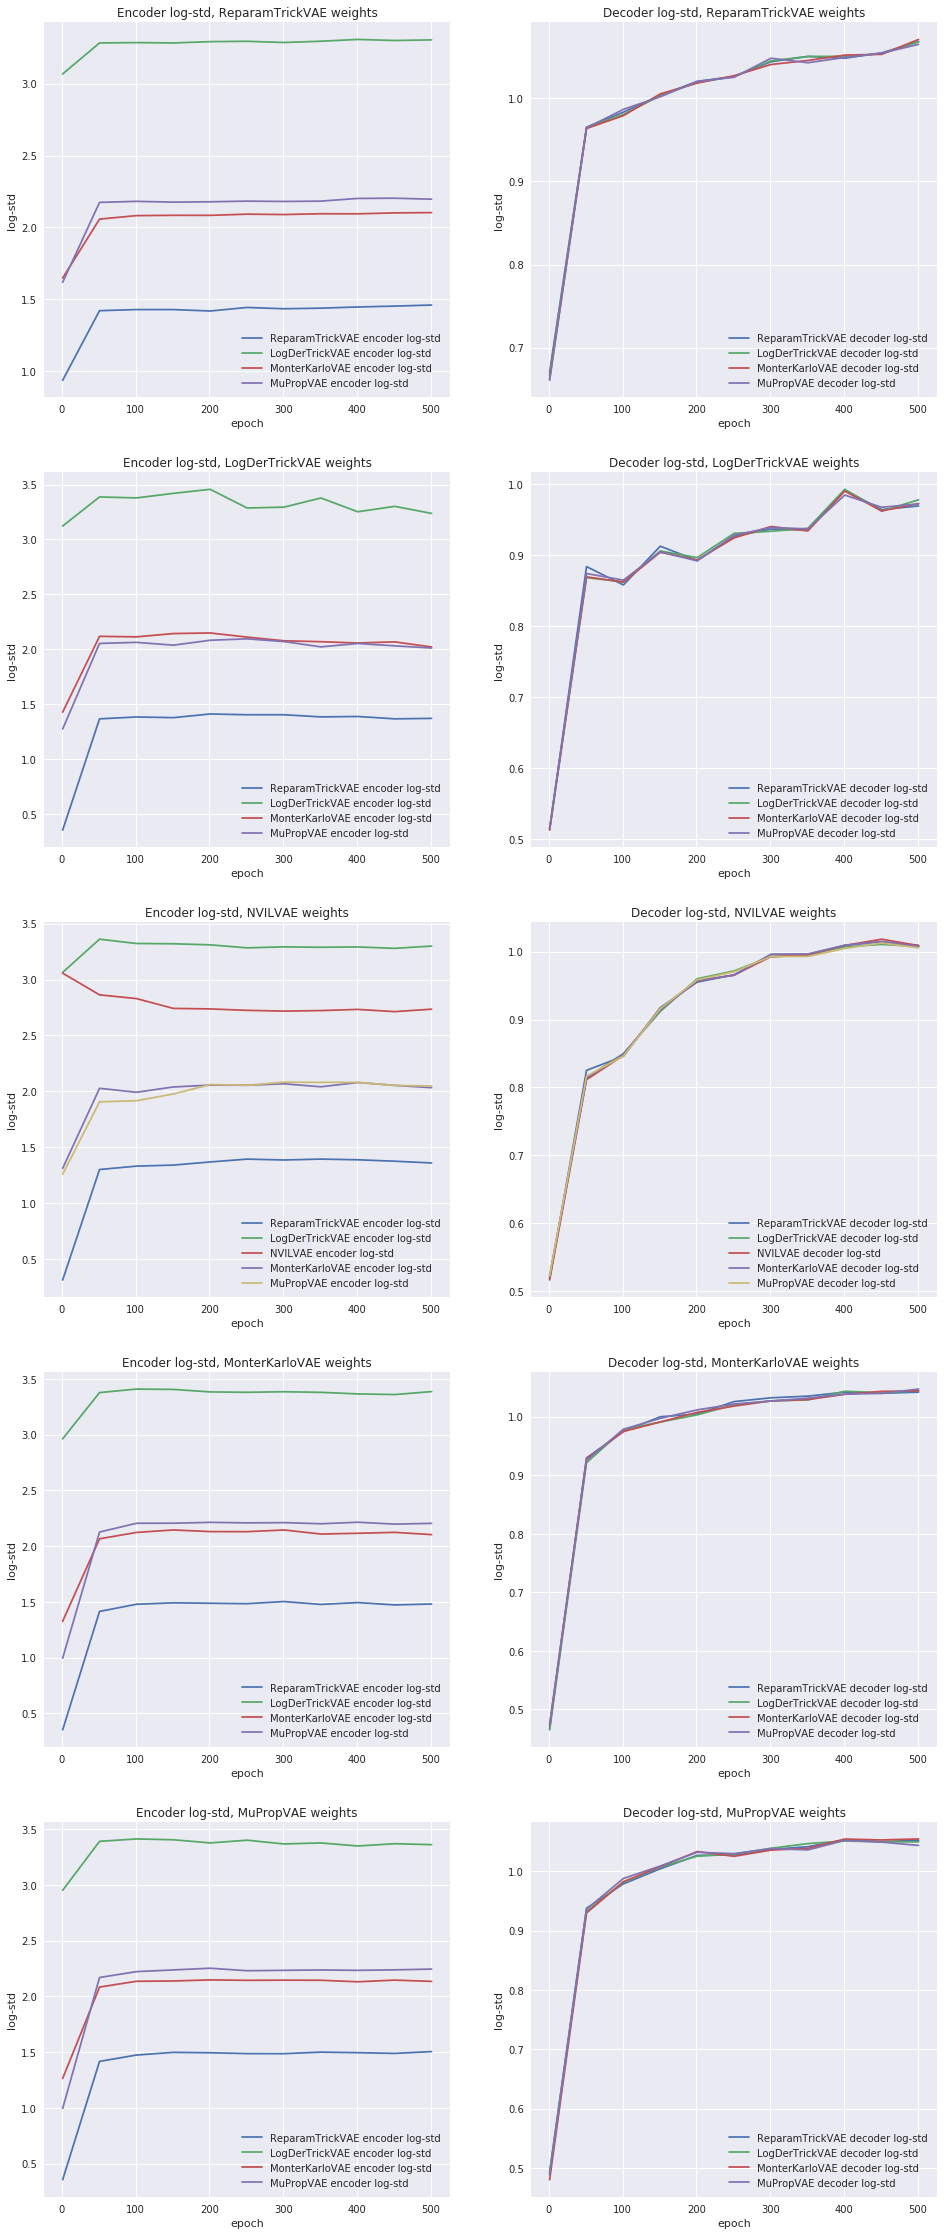

In [9]:
n_vaes = len(vaes)
weights_range = np.arange(1, training_epochs+1, weights_save_step)

fig, axes = plt.subplots(n_vaes, 2, figsize=(16, 40))
for idx, weights_name in enumerate(names):
    for name in names:
        if name == 'NVILVAE' and weights_name != 'NVILVAE':
            continue
        axes[idx][0].plot(weights_range, np.log10(encoder_stds[weights_name][name]), 
                          label='{} encoder log-std'.format(name))
        axes[idx][1].plot(weights_range, np.log10(decoder_stds[weights_name][name]), 
                          label='{} decoder log-std'.format(name))
    axes[idx][0].set_title('Encoder log-std, {} weights'.format(weights_name))
    axes[idx][0].set_xlabel('epoch')
    axes[idx][0].set_ylabel('log-std')
    axes[idx][0].legend(loc='best')
    
    axes[idx][1].set_title('Decoder log-std, {} weights'.format(weights_name))
    axes[idx][1].set_xlabel('epoch')
    axes[idx][1].set_ylabel('log-std')
    axes[idx][1].legend(loc='best')
plt.show()

### Difference between the gradient means

In [16]:
min_iterations = 100
max_iterations = 1001
step = 100
weights_save_step = 250

In [20]:
encoder_gradients_mean = defaultdict(lambda: defaultdict(list))
decoder_gradients_mean = defaultdict(lambda: defaultdict(list))
weights_name = 'NVILVAE'
for name, vae in tqdm(zip(names, vaes)):
    for saved_index in range(1, training_epochs+1, weights_save_step):
        vae.restore_weights(save_path + weights_name + '_{}'.format(saved_index))
        for n_iterations in range(min_iterations, max_iterations, step):
            mean, _ = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'encoder')
            encoder_gradients_mean[name][saved_index].append(mean)
            mean, _ = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'decoder')
            decoder_gradients_mean[name][saved_index].append(mean)

5it [27:03, 329.41s/it]


In [21]:
first_name = names[0]
names = names[1:]

In [22]:
encoder_gradients_delta = defaultdict(lambda: defaultdict(list))
decoder_gradients_delta = defaultdict(lambda: defaultdict(list))
for name in tqdm(names):
    for saved_index in range(1, training_epochs+1, weights_save_step):
        for first_mean, mean in zip(encoder_gradients_mean[first_name][saved_index], 
                                    encoder_gradients_mean[name][saved_index]):
            encoder_gradients_delta[name][saved_index].append(np.linalg.norm(mean - first_mean))
        for first_mean, mean in zip(decoder_gradients_mean[first_name][saved_index], 
                                    decoder_gradients_mean[name][saved_index]):
            decoder_gradients_delta[name][saved_index].append(np.linalg.norm(mean - first_mean))

100%|██████████| 4/4 [00:00<00:00, 51.17it/s]


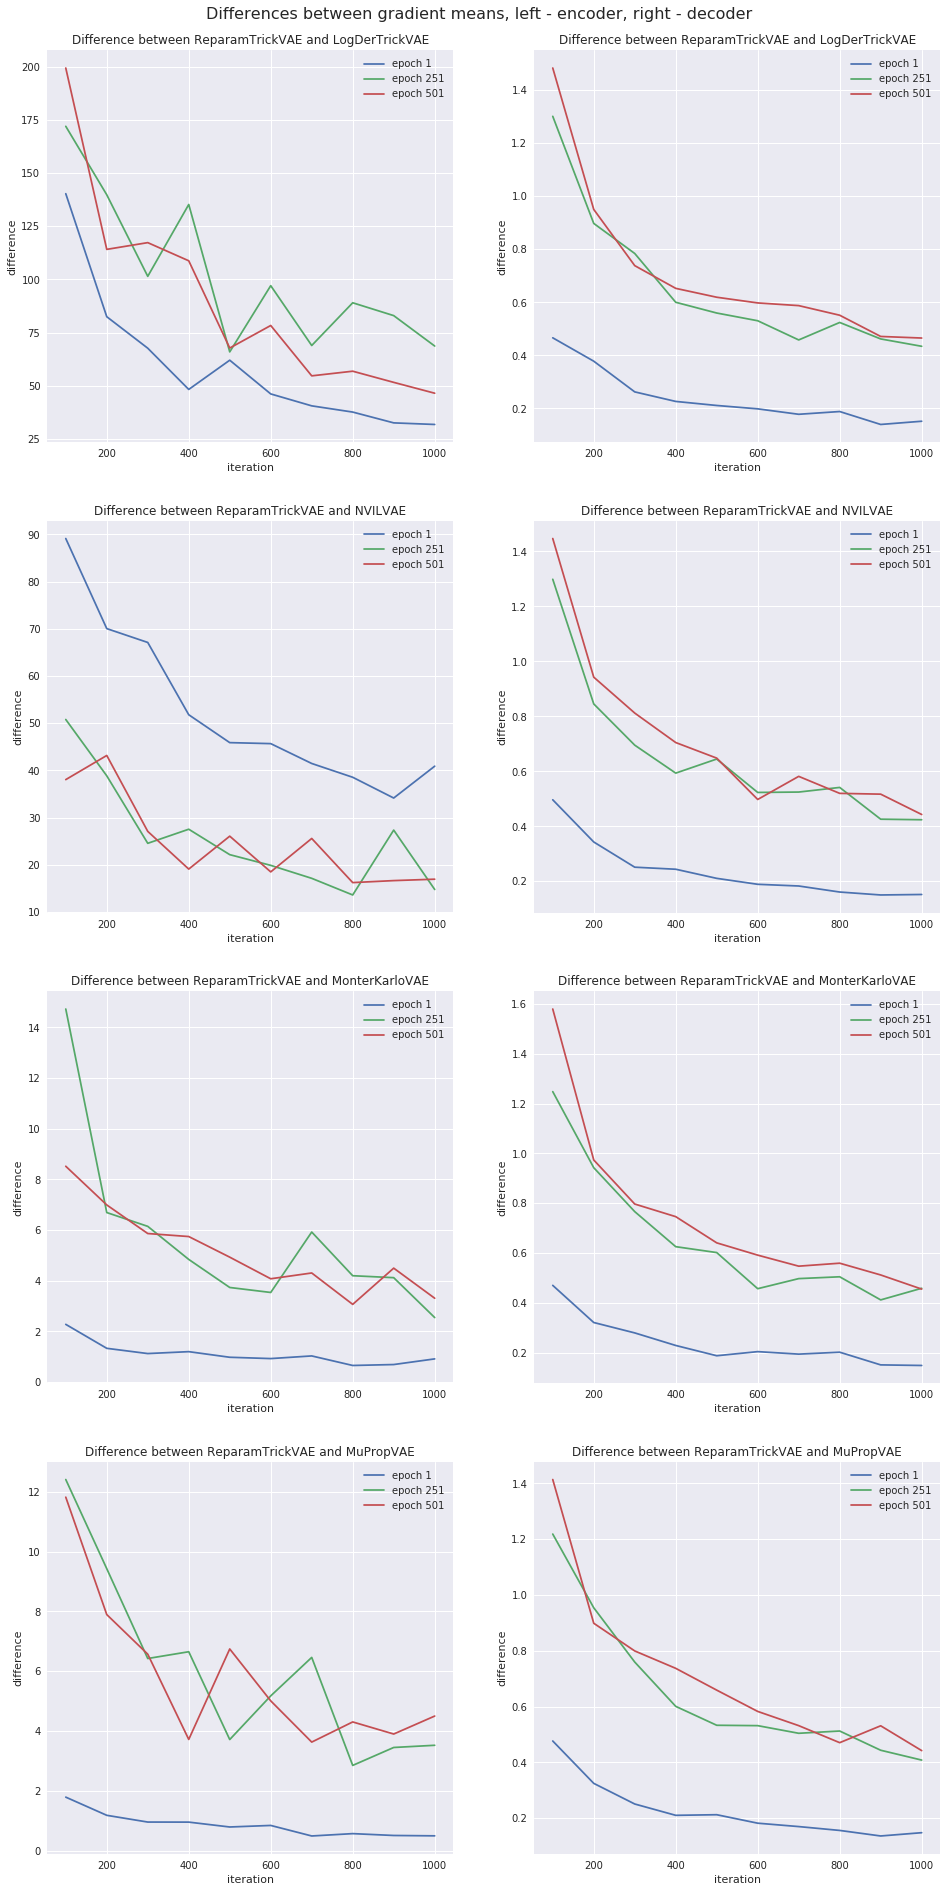

In [23]:
n_vaes = len(names)
iterations_range = np.arange(min_iterations, max_iterations, step)

fig, axes = plt.subplots(n_vaes, 2, figsize=(16, 30))
fig.subplots_adjust(top=0.96)
fig.suptitle('Differences between gradient means, left - encoder, right - decoder', fontsize=16)
for idx, name in enumerate(names):
    for saved_index in encoder_gradients_delta[name].keys():
        axes[idx][0].plot(iterations_range, encoder_gradients_delta[name][saved_index], 
                          label='epoch {}'.format(saved_index))
        axes[idx][1].plot(iterations_range, decoder_gradients_delta[name][saved_index], 
                          label='epoch {}'.format(saved_index))
    axes[idx][0].set_title('Difference between {} and {}'.format(first_name, name))
    axes[idx][0].set_xlabel('iteration')
    axes[idx][0].set_ylabel('difference')
    axes[idx][0].legend(loc='best')
    
    axes[idx][1].set_title('Difference between {} and {}'.format(first_name, name))
    axes[idx][1].set_xlabel('iteration')
    axes[idx][1].set_ylabel('difference')
    axes[idx][1].legend(loc='best')
plt.show()